In [1]:
import re
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import cellrank as cr
from scipy import sparse
from anndata import AnnData
import matplotlib.cm as cm
import os

sc.set_figure_params(dpi=100, color_map='viridis', fontsize=6)
sc.settings.verbosity=2
sc.settings.n_jobs=16
cr.settings.verbosity = 2
scv.settings.verbosity = 3
#sc.logging.print_versions()

stype = "CD8"
oDir = os.path.abspath("./OUT_FigS13")

if not os.path.exists(oDir):
    os.makedirs(oDir)
os.chdir(oDir)

In [2]:
adata = sc.read(f"{oDir}/../../data/velo/adata_mini_{stype}.h5ad")

In [3]:
## add cellInfo
cellInfo = pd.read_csv(f"{oDir}/../../data/metaInfo/{stype}.miniInfo.txt.gz", compression='gzip', sep="\t", header=0, index_col=0)
cellInfo = cellInfo.loc[list(adata.obs_names), [not bool(re.match('RNA_', i)) for i in cellInfo.columns] ]
adata.obs = cellInfo
#
adata.obs['cancerType'] = [re.sub('\\..*', '', i) for i in np.array(adata.obs.dataset)]
#np.savetxt(f"{oDir}/../cancerType.lst", adata.obs.cancerType.unique(), fmt="%s")

In [4]:
## add embedding & subset
redim1 = pd.read_csv(f"{oDir}/../../data/metaInfo/{stype}.diffMap.txt.gz", compression='gzip', sep="\t", header=0, index_col=0)
redim1 = redim1.loc[list(adata.obs_names), redim1.columns[1:]]  ## diffmap 0-col is non-informative
#
adata.obsm['X_DiffMap'] = np.array(redim1)

In [5]:
## add colSet
adata.obs["meta.cluster"] = adata.obs["meta.cluster"].astype('category')
color = pd.read_csv(f"{oDir}/../../data/metaInfo/color_meta.cluster_.txt.gz", compression='gzip', sep="\t", header=None, index_col=0)
color_used = list(color.loc[adata.obs["meta.cluster"].cat.categories,1])
adata.uns['meta.cluster_colors'] = color_used

In [6]:
adata

AnnData object with n_obs × n_vars = 4099 × 33694
    obs: 'dataset', 'dataset.tech', 'meta.cluster', 'cancerType'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr'
    uns: 'meta.cluster_colors'
    obsm: 'X_DiffMap'
    layers: 'spliced', 'unspliced'

# scVelo

In [7]:
scv.pp.filter_and_normalize(adata, min_shared_cells=30, log=True)

Filtered out 23122 genes that are detected in less than 30 cells (shared).
Logarithmized X.


In [8]:
adata.X.shape

(4099, 10572)

calculating cell cycle phase
computing score 'S_score'
    finished (0:00:00)
computing score 'G2M_score'
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


... storing 'dataset' as categorical
... storing 'dataset.tech' as categorical
... storing 'cancerType' as categorical
... storing 'phase' as categorical


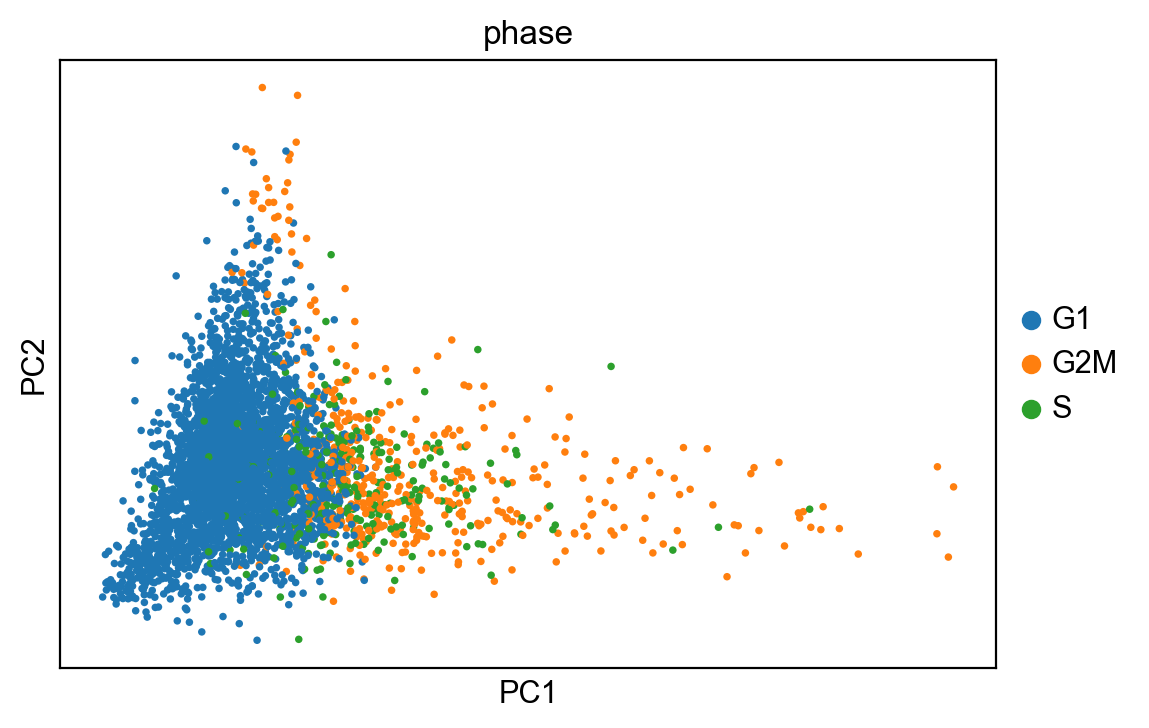

regressing out ['S_score', 'G2M_score']
    sparse input is densified and may lead to high memory use


... storing 'dataset' as categorical
... storing 'dataset.tech' as categorical
... storing 'cancerType' as categorical
... storing 'phase' as categorical


    finished (0:01:03)
computing PCA
    with n_comps=50
    finished (0:00:00)


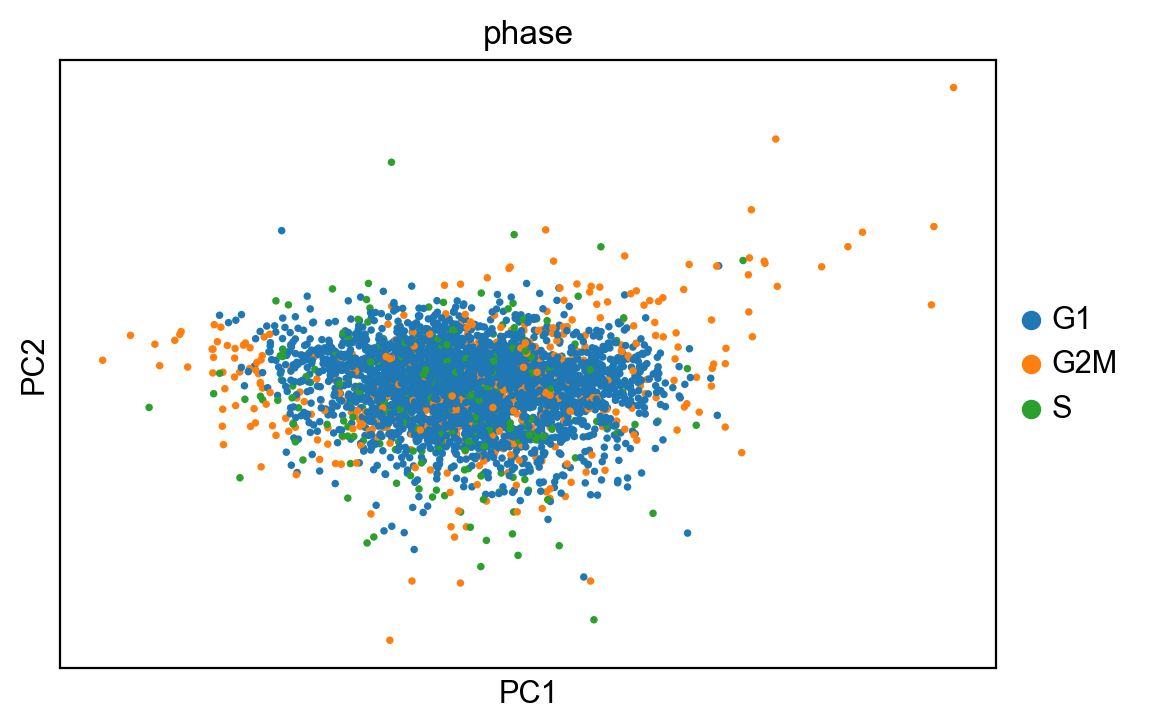

In [9]:
## read cycling genes
cell_cycle_genes = [x.strip() for x in open(f"{oDir}/../../data/external/regev_lab_cell_cycle_genes.txt")]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

## compute score
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

#plot
scv.settings.set_figure_params('scvelo', dpi=100)
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

## regress and scale
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
sc.pp.scale(adata)

#plot
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

In [10]:
## subset genes
genes = pd.read_csv(f"{oDir}/../../data/metaInfo/int.{stype}.genes.txt", header=None, index_col=0)
select_genes = list(set(genes.index) & set(adata.var_names))
#
adata.raw = adata
adata = adata[:,select_genes]

In [11]:
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

computing PCA
    with n_comps=30
    finished (0:00:07)
computing neighbors
    finished (0:00:12) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [12]:
scv.tl.recover_dynamics(adata, var_names=select_genes, n_jobs=32) # var_names=select_genes
scv.tl.velocity(adata, mode='dynamical', min_r2=None)
scv.tl.velocity_graph(adata)

recovering dynamics (using 32/64 cores)



    finished (0:04:45) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_DiffMap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_.CD8_global.pdf


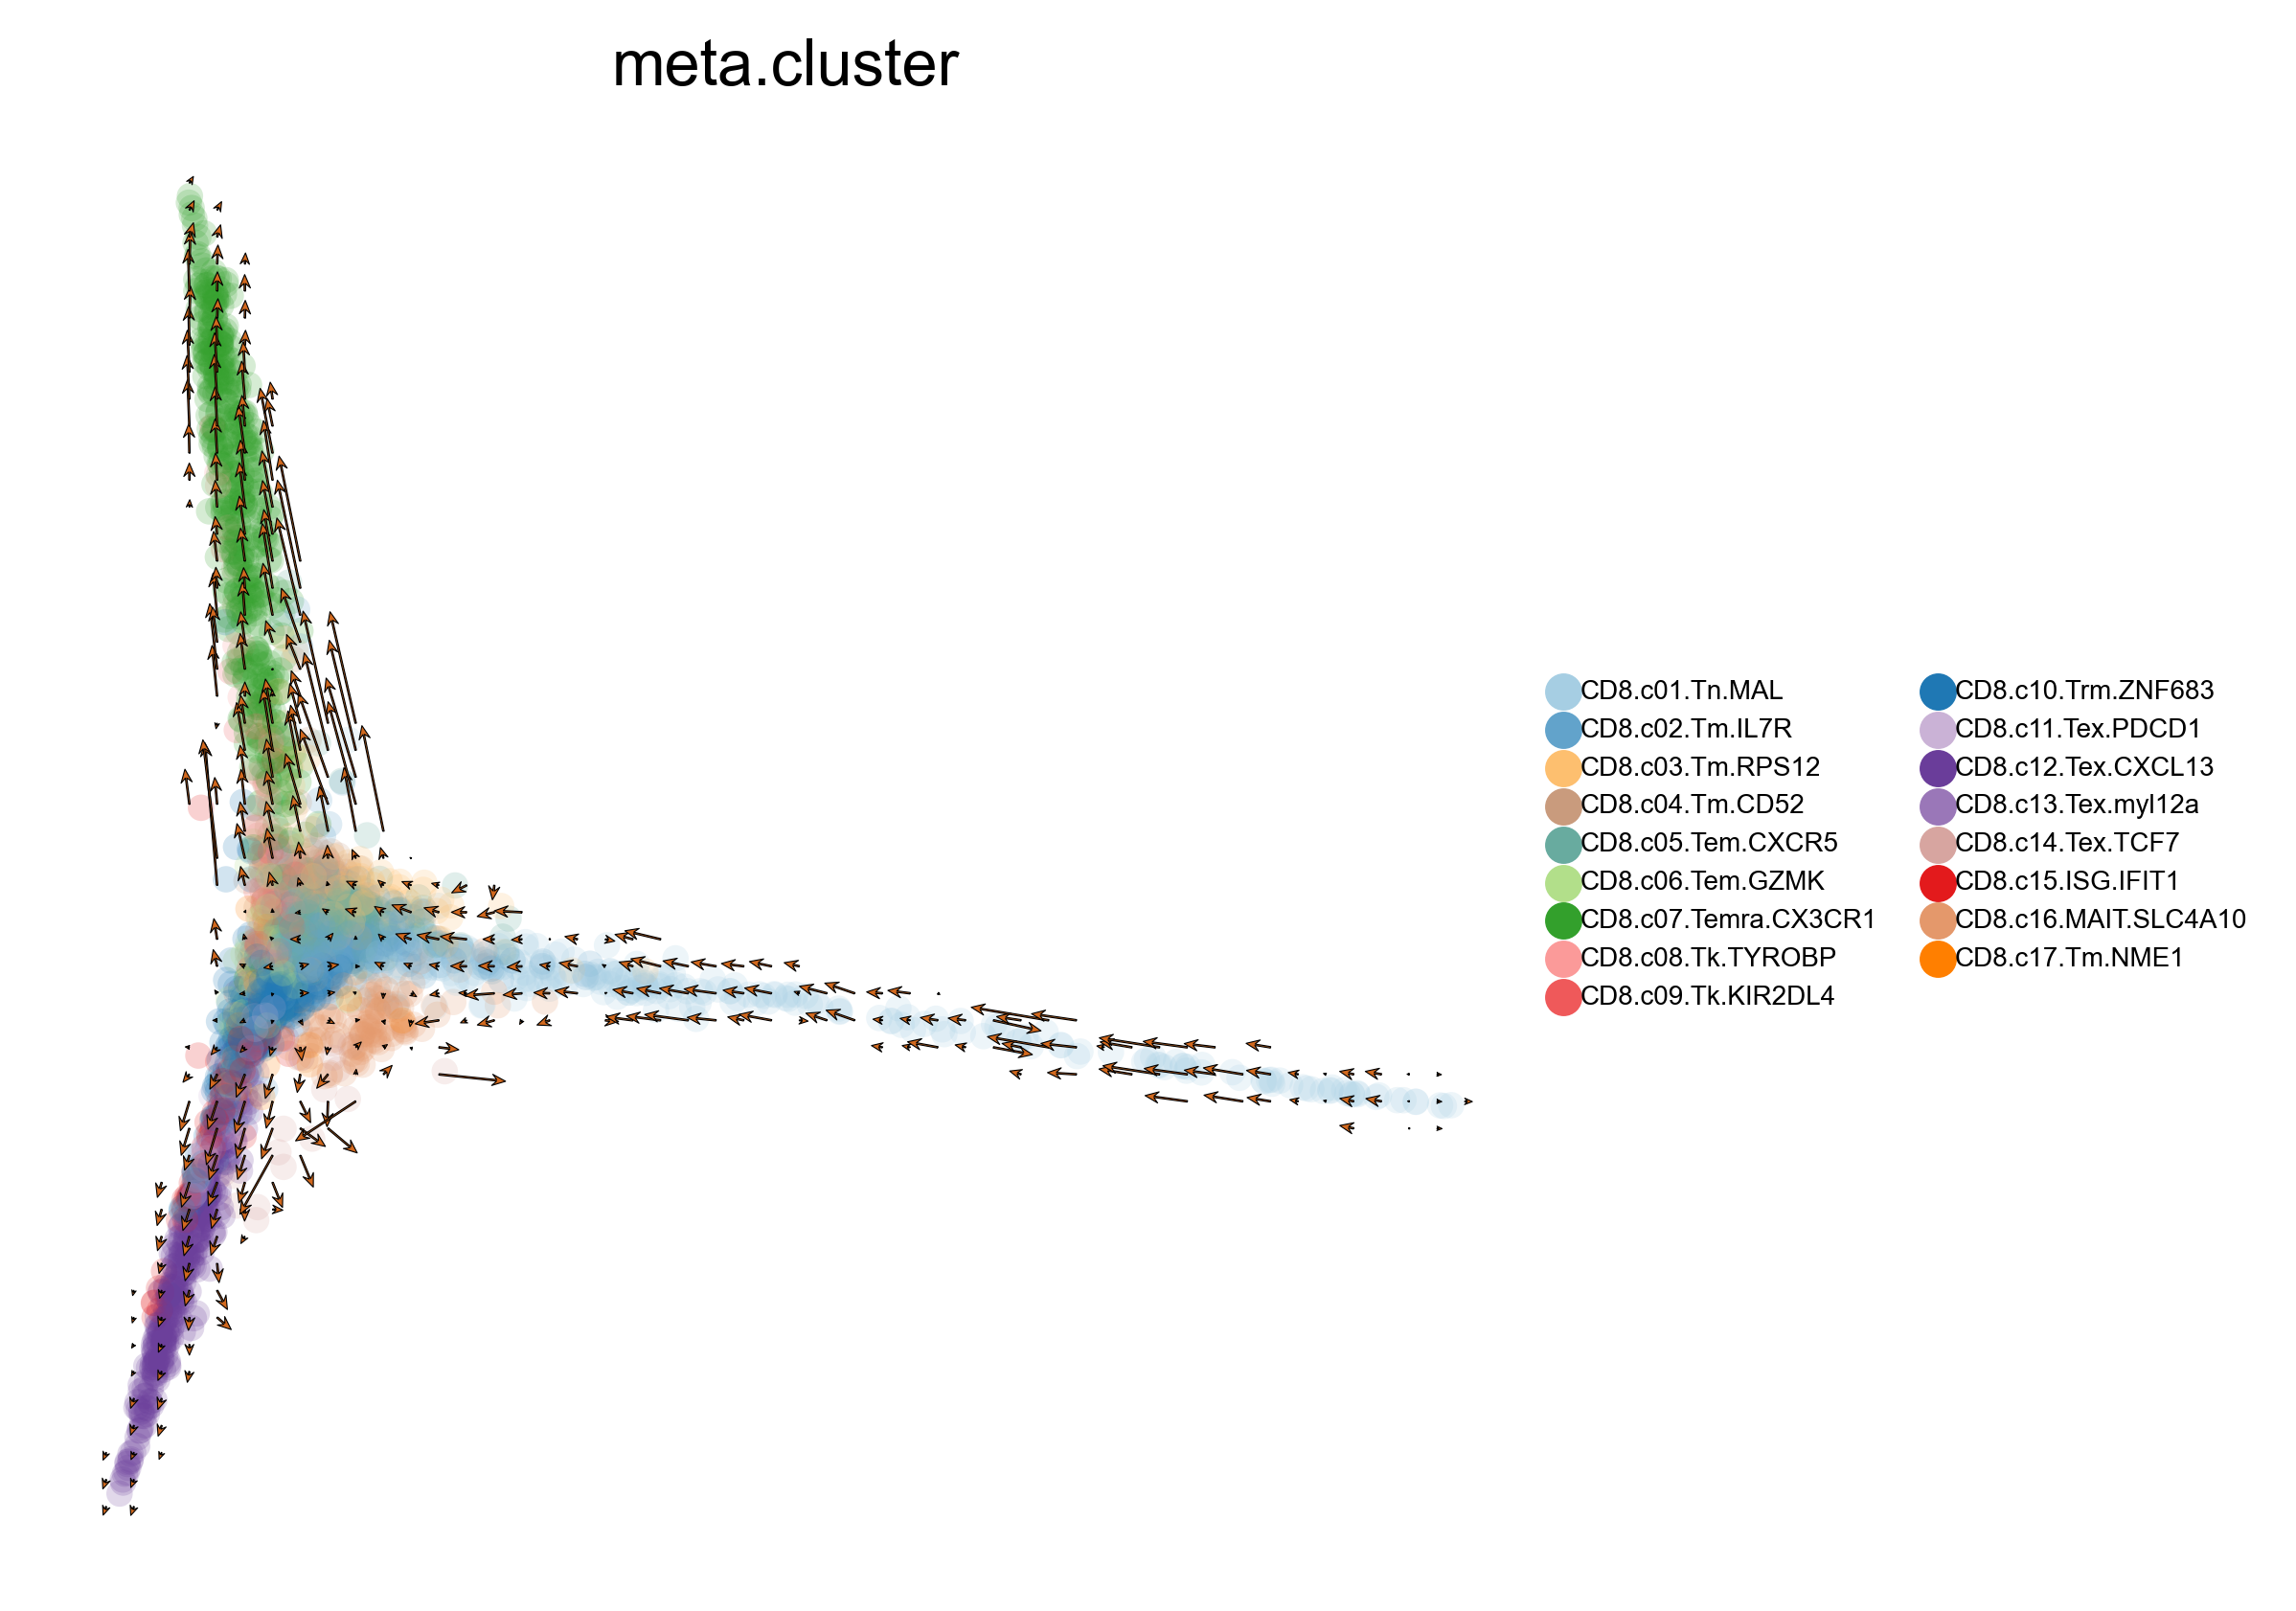

In [13]:
scv.settings.set_figure_params('scvelo', dpi=200)
scv.pl.velocity_embedding_grid(adata, basis='DiffMap',color='meta.cluster',arrow_size=1.5, arrow_length=1.5,arrow_color="#D2691E",
                               legend_loc='right margin',legend_fontsize=5,
                               save=f".{stype}_global.pdf", figsize=(5,5))

saving figure to file ./figures/scvelo__stream.CD8_global.png


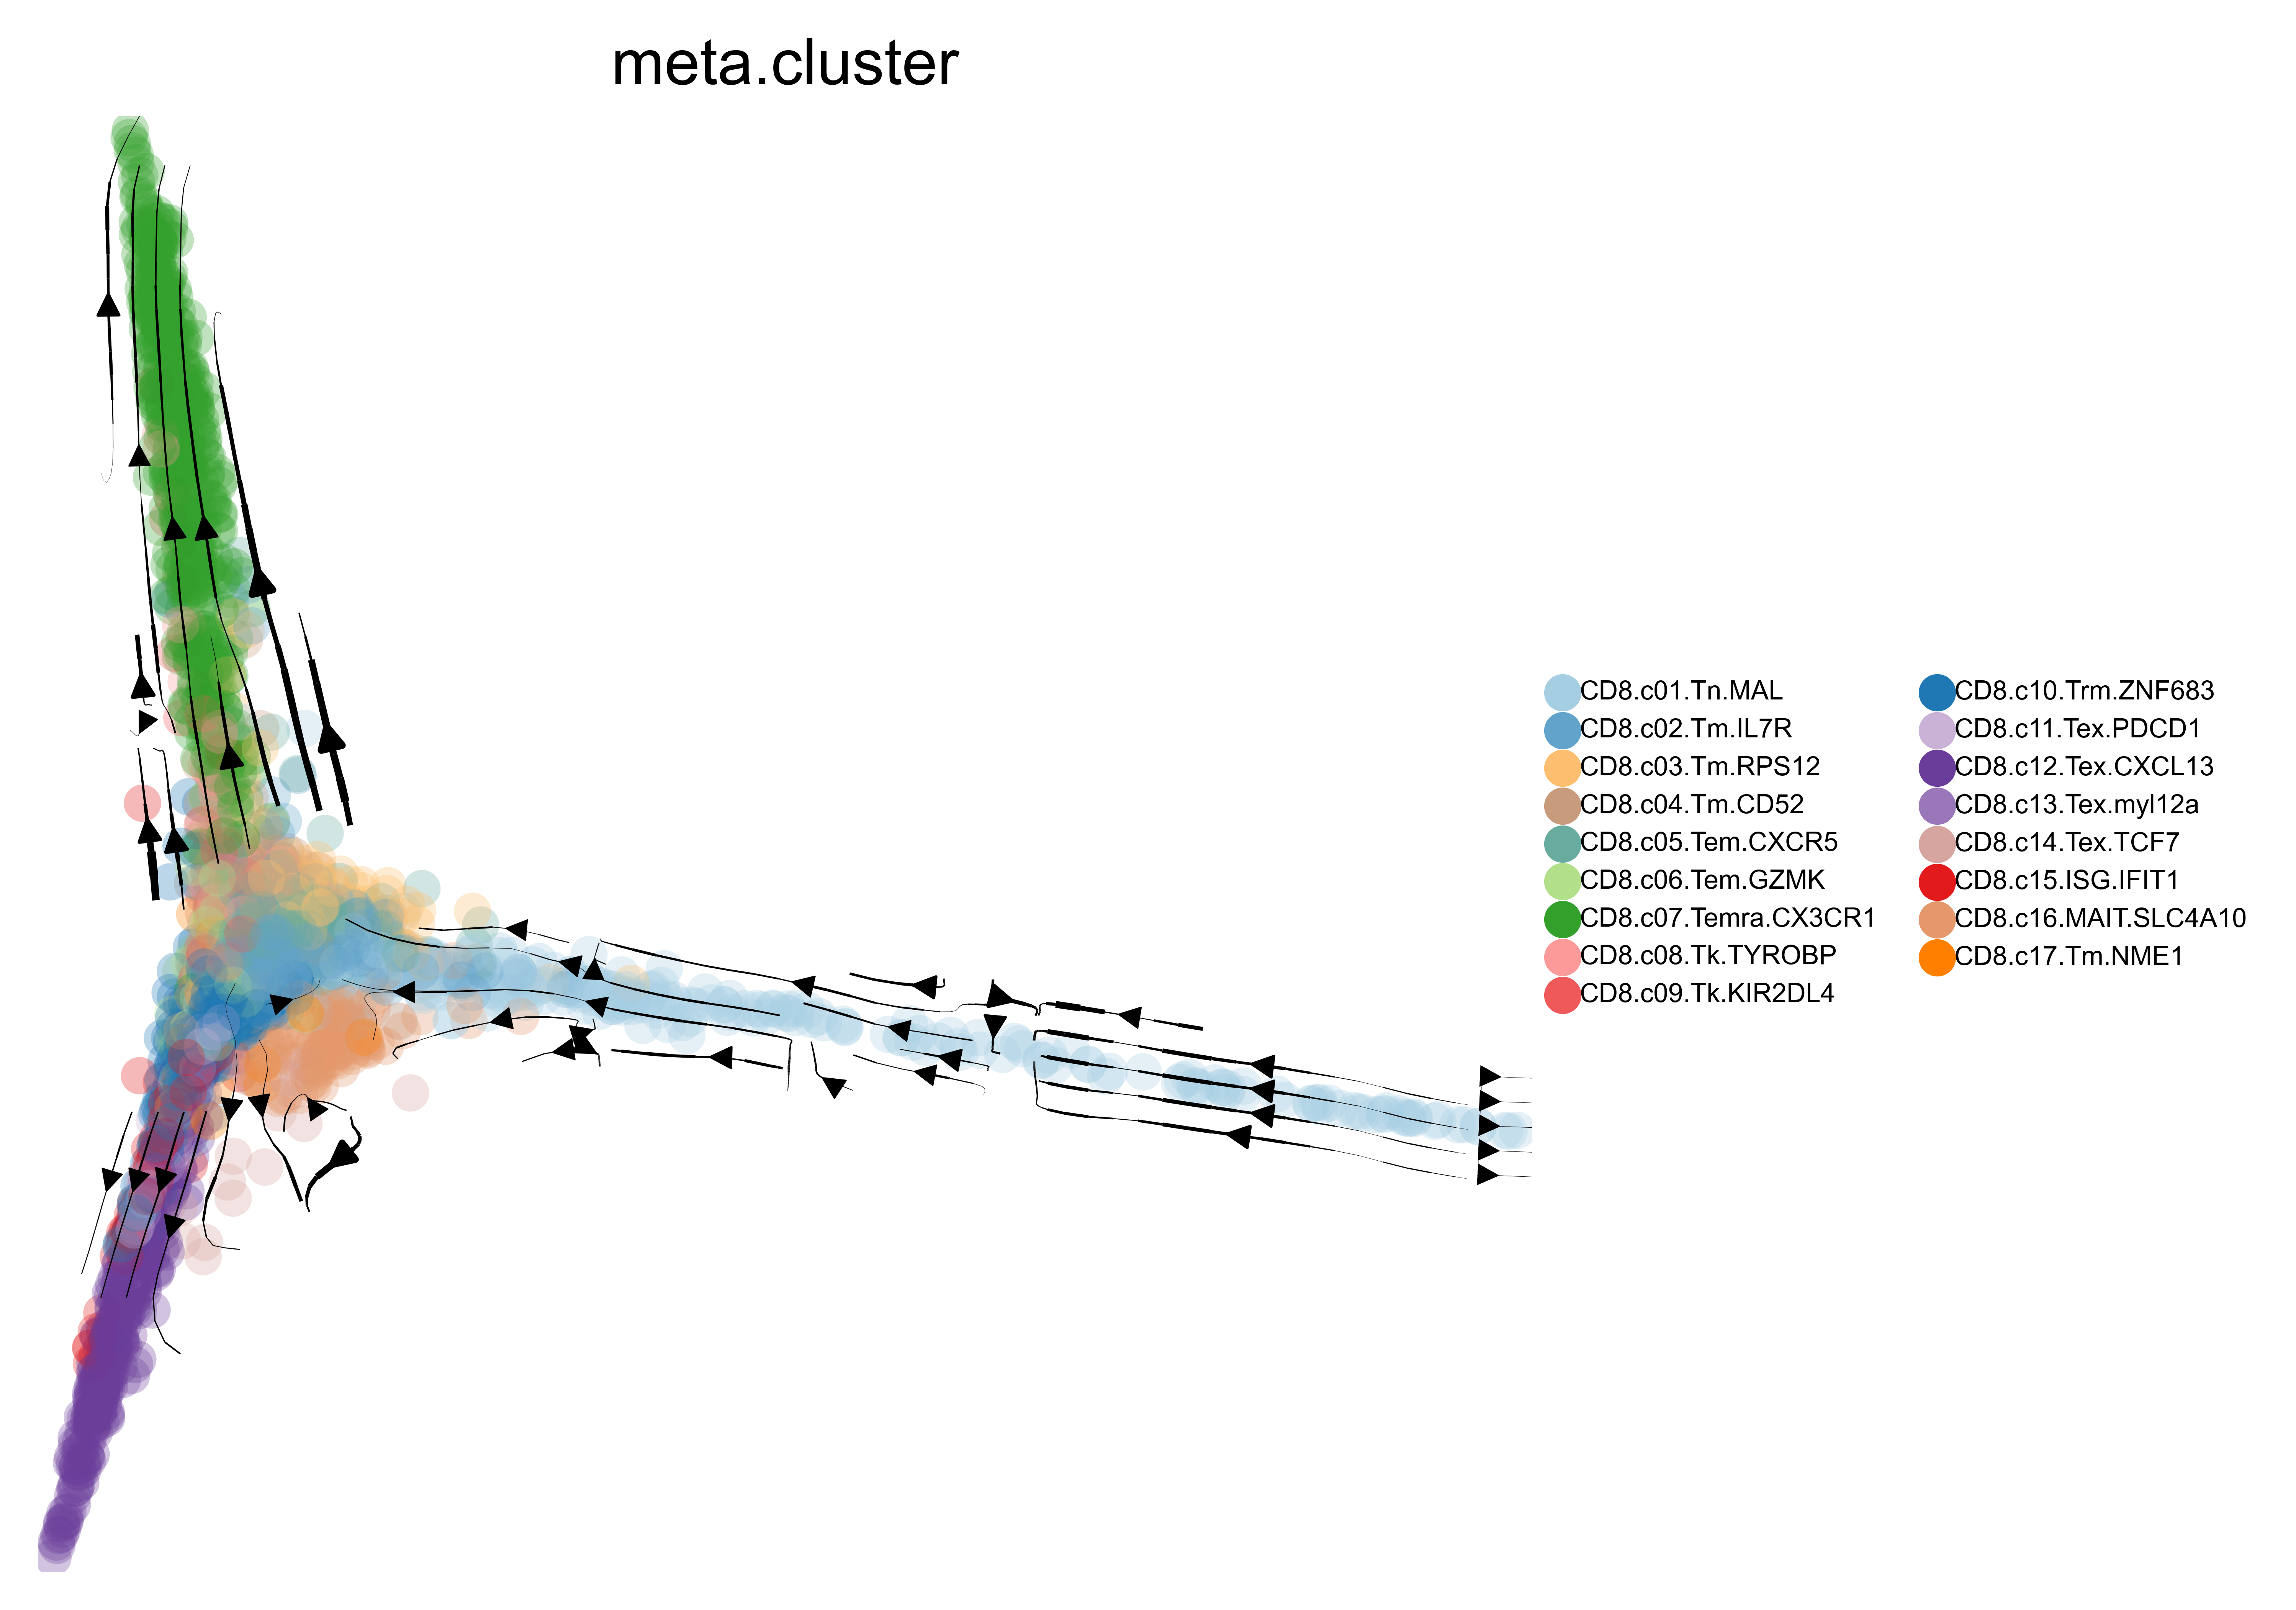

In [14]:
scv.settings.set_figure_params('scvelo', dpi=500)
scv.pl.velocity_embedding_stream(adata, basis='DiffMap',color='meta.cluster',
                                 legend_loc='right margin',legend_fontsize=5,
                                 save=f"_stream.{stype}_global.png", figsize=(5,5))

In [15]:
adata.write(f"{oDir}/{stype}_global.velo.h5ad")
#adata = sc.read_h5ad(f"{oDir}/{stype}_global.velo.h5ad")